# Imports

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt

# Import data

https://www.cset-foretell.com/questions/95-what-will-be-the-value-in-dollars-of-all-chinese-imports-of-semiconductor-manufacturing-equipment-in-2021

In [2]:
# Data from https://docs.google.com/spreadsheets/d/16xMAb9QYm_SD0cUwjMjQKkDiQvmFx41XB6l2yzpzMYI/edit#gid=604195616
data = {"date": np.array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]) - 2011,
       "quant": np.array([18435930878, 7964069660, 9122348976, 12150657774, 13284121039, 15047428288, 20821423456, 
                          32522854432, 28502720773]) * 1e-9}

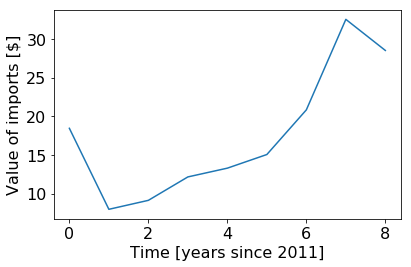

In [3]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,1)

ax.plot(data['date'], data['quant'])
ax.set_xlabel('Time [years since 2011]')
ax.set_ylabel('Value of imports [$]')

plt.tight_layout()

# Generate trend-fit values, linear

In [12]:
def outside_func(t, m, b):
    return m*t + b

In [13]:
slope_guess = 2 # $2billion / year
offs_guess = 10
popt, pcov = sp.optimize.curve_fit(outside_func, data['date'], data['quant'], p0=[slope_guess, offs_guess])
perr = np.sqrt(np.diag(pcov)) # The standard deviations of the parameters

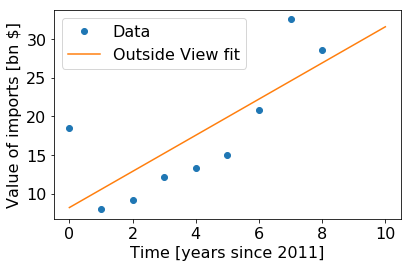

In [14]:
fig, ax = plt.subplots(1,1)

ax.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, 10, 100)
ax.plot(t_plot, outside_func(t_plot, *popt), label='Outside View fit')
ax.set_xlabel('Time [years since 2011]')
ax.set_ylabel('Value of imports [bn $]')

ax.legend()

plt.tight_layout()

In [15]:
outside_func(10, *popt)

31.56290495202296

## Outside view Monte Carlo

I think with the fit we could probably just build up the probability density function P(y) =  Pr(f(x) = y) for the ranges of y we care about, just given our fit parameters for x. However, I think an equivalent way to do this is to just run a monte carlo simulation were we randomly sample from our fit parameters, and then bin the value of f(x) that we get from the simulation

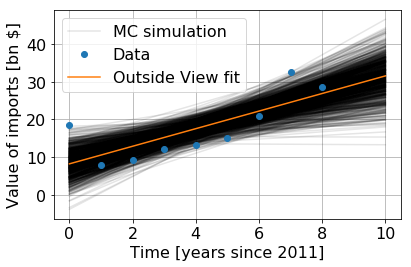

In [19]:
# Generate fits

n_fits = 1000
fit_params_gen = np.random.multivariate_normal(popt, pcov, n_fits)

fit_params = fit_params_gen
# Comment out the line above and uncomment the below lines to clean to fit based on some criteria. 
# Be very careful throwing only a lot of data though!!
# fit_params = []
# n_removed = 0
# for fit_list in fit_params_gen:
#     if fit_list[0] < 0:
#         n_removed += 1
#         n_fits -= 1
#     else:
#         fit_params.append(fit_list)


# Plot MC simualtions and build MC data
fig, ax_mc = plt.subplots(1,1)

final_vals = []
for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, 10, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
    
    final_vals.append(outside_func(np.array([10]), *popt_mc)[0])
    
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, 10, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label='Outside View fit')

ax_mc.set_xlabel('Time [years since 2011]')
ax_mc.set_ylabel('Value of imports [bn $]')

ax_mc.grid()
ax_mc.legend()

plt.tight_layout()

## Histogramming

In [20]:
# cset_boundaries = [20, 30, 40, 50]
# bins = [ax_mc.get_ylim()[0], 20, 30, 40, 50, ax_mc.get_ylim()[1]]

# fig, ax_hist = plt.subplots(1,1)

# n, bins, patches = ax_hist.hist(np.array(final_vals), bins, color='k', orientation='horizontal')
# ax_hist.set_ylim(ax_mc.get_ylim())

# ax_hist.set_xlabel('Num occurences of {} sims'.format(n_fits))

# for boundary in cset_boundaries:
#     ax_hist.axhline(boundary, color='r')
    
# text_offset = (max(bins) - min(bins)) / 100
# percentages = [int(n_val / n_fits * 100) for n_val in n]
# for n_val, bin_min, percent in zip(n, bins[:-1], percentages):
#     ax_hist.text(n_val, bin_min + text_offset, '{}%'.format(percent))

## Combine plots

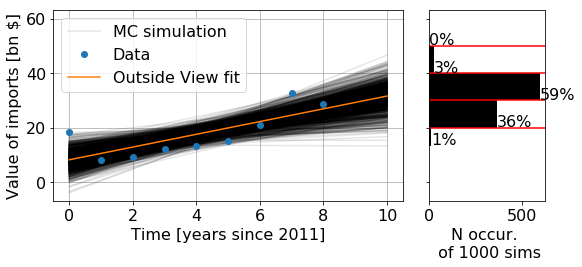

In [24]:
# Plot MC simualtions and build MC data
cset_boundaries = [20, 30, 40, 50]

fig, [ax_mc, ax_hist] = plt.subplots(1, 2, figsize=(8, 4), sharey=True, gridspec_kw={'width_ratios': [3, 1]})

# for i, popt_mc in enumerate(fit_params.transpose()):
for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, 10, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
        
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, 10, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label='Outside View fit')

ax_mc.set_xlabel('Time [years since 2011]')
ax_mc.set_ylabel('Value of imports [bn $]')

ax_mc.grid()
ax_mc.legend()


# Plot histogram
bin_min = min(final_vals) if min(final_vals) < min(cset_boundaries) else min(cset_boundaries) - np.diff(cset_boundaries)[0]
bin_max = max(final_vals) if max(final_vals) > max(cset_boundaries) else max(cset_boundaries) + np.diff(cset_boundaries)[-1]

bins = np.concatenate([[bin_min], cset_boundaries, [bin_max]])

n, bins, patches = ax_hist.hist(np.array(final_vals), bins, color='k', orientation='horizontal')
# ax_hist.set_ylim(ax_mc.get_ylim())

ax_hist.set_xlabel('N occur. \n of {} sims'.format(n_fits))

for boundary in cset_boundaries:
    ax_hist.axhline(boundary, color='r')
    
text_offset = (max(bins) - min(bins)) / 100
percentages = [int(np.round(n_val / n_fits * 100)) for n_val in n]
for n_val, bin_min, percent in zip(n, bins[:-1], percentages):
    ax_hist.text(n_val, bin_min + text_offset, '{}%'.format(percent))


plt.tight_layout()

# Generate trend-fit values, linear, removing first data point

In [25]:
def outside_func(t, m, b):
    return m*t + b

In [26]:
slope_guess = 2 # $2billion / year
offs_guess = 10
popt, pcov = sp.optimize.curve_fit(outside_func, data['date'][1:], data['quant'][1:], p0=[slope_guess, offs_guess])
perr = np.sqrt(np.diag(pcov)) # The standard deviations of the parameters

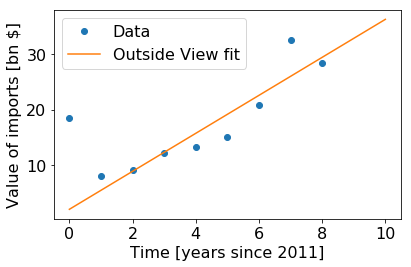

In [27]:
fig, ax = plt.subplots(1,1)

ax.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, 10, 100)
ax.plot(t_plot, outside_func(t_plot, *popt), label='Outside View fit')
ax.set_xlabel('Time [years since 2011]')
ax.set_ylabel('Value of imports [bn $]')

ax.legend()

plt.tight_layout()

## Outside view Monte Carlo

I think with the fit we could probably just build up the probability density function P(y) =  Pr(f(x) = y) for the ranges of y we care about, just given our fit parameters for x. However, I think an equivalent way to do this is to just run a monte carlo simulation were we randomly sample from our fit parameters, and then bin the value of f(x) that we get from the simulation

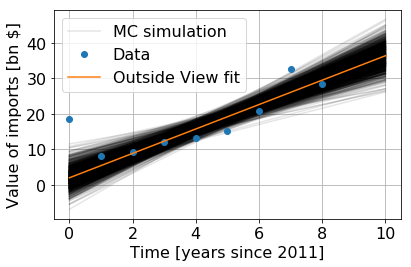

In [28]:
# Generate fits

n_fits = 1000
fit_params_gen = np.random.multivariate_normal(popt, pcov, n_fits)

fit_params = fit_params_gen
# Comment out the line above and uncomment the below lines to clean to fit based on some criteria. 
# Be very careful throwing only a lot of data though!!
# fit_params = []
# n_removed = 0
# for fit_list in fit_params_gen:
#     if fit_list[0] < 0:
#         n_removed += 1
#         n_fits -= 1
#     else:
#         fit_params.append(fit_list)

# Plot MC simualtions and build MC data
fig, ax_mc = plt.subplots(1,1)

final_vals = []
for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, 10, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
    
    final_vals.append(outside_func(np.array([10]), *popt_mc)[0])
    
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, 10, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label='Outside View fit')

ax_mc.set_xlabel('Time [years since 2011]')
ax_mc.set_ylabel('Value of imports [bn $]')

ax_mc.grid()
ax_mc.legend()

plt.tight_layout()

## Histogramming

In [29]:
# cset_boundaries = [20, 30, 40, 50]
# bins = [ax_mc.get_ylim()[0], 20, 30, 40, 50, ax_mc.get_ylim()[1]]

# fig, ax_hist = plt.subplots(1,1)

# n, bins, patches = ax_hist.hist(np.array(final_vals), bins, color='k', orientation='horizontal')
# ax_hist.set_ylim(ax_mc.get_ylim())

# ax_hist.set_xlabel('Num occurences of {} sims'.format(n_fits))

# for boundary in cset_boundaries:
#     ax_hist.axhline(boundary, color='r')
    
# text_offset = (max(bins) - min(bins)) / 100
# percentages = [int(n_val / n_fits * 100) for n_val in n]
# for n_val, bin_min, percent in zip(n, bins[:-1], percentages):
#     ax_hist.text(n_val, bin_min + text_offset, '{}%'.format(percent))

## Combine plots

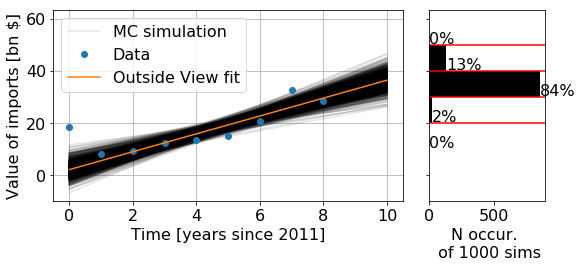

In [30]:
# Plot MC simualtions and build MC data
cset_boundaries = [20, 30, 40, 50]

fig, [ax_mc, ax_hist] = plt.subplots(1, 2, figsize=(8, 4), sharey=True, gridspec_kw={'width_ratios': [3, 1]})

# for i, popt_mc in enumerate(fit_params.transpose()):
for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, 10, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
        
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, 10, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label='Outside View fit')

ax_mc.set_xlabel('Time [years since 2011]')
ax_mc.set_ylabel('Value of imports [bn $]')

ax_mc.grid()
ax_mc.legend()


# Plot histogram
bin_min = min(final_vals) if min(final_vals) < min(cset_boundaries) else min(cset_boundaries) - np.diff(cset_boundaries)[0]
bin_max = max(final_vals) if max(final_vals) > max(cset_boundaries) else max(cset_boundaries) + np.diff(cset_boundaries)[-1]

bins = np.concatenate([[bin_min], cset_boundaries, [bin_max]])

n, bins, patches = ax_hist.hist(np.array(final_vals), bins, color='k', orientation='horizontal')
# ax_hist.set_ylim(ax_mc.get_ylim())

ax_hist.set_xlabel('N occur. \n of {} sims'.format(n_fits))

for boundary in cset_boundaries:
    ax_hist.axhline(boundary, color='r')
    
text_offset = (max(bins) - min(bins)) / 100
percentages = [int(np.round(n_val / n_fits * 100)) for n_val in n]
for n_val, bin_min, percent in zip(n, bins[:-1], percentages):
    ax_hist.text(n_val, bin_min + text_offset, '{}%'.format(percent))


plt.tight_layout()

# Generate outside view parameters, exponential

In [31]:
def outside_func(t, a, tau, b):
    return a * np.exp(t/tau) + b

In [32]:
a_guess = 5
tau_guess = 5
b_guess = 5
popt, pcov = sp.optimize.curve_fit(outside_func, data['date'], data['quant'], p0=[a_guess, tau_guess, b_guess])
perr = np.sqrt(np.diag(pcov)) # The standard deviations of the parameters

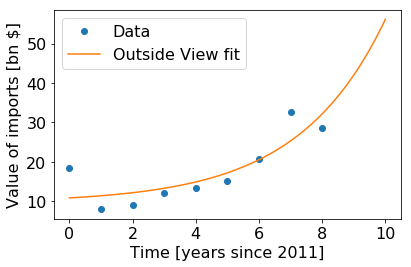

In [33]:
fig, ax = plt.subplots(1,1)

ax.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, 10, 100)
ax.plot(t_plot, outside_func(t_plot, *popt), label='Outside View fit')
ax.set_xlabel('Time [years since 2011]')
ax.set_ylabel('Value of imports [bn $]')

ax.legend()

plt.tight_layout()

In [34]:
popt

array([1.24352162, 2.76066693, 9.60980951])

In [35]:
perr

array([2.89271873, 2.092113  , 5.74740379])

## Outside view Monte Carlo

I think with the fit we could probably just build up the probability density function P(y) =  Pr(f(x) = y) for the ranges of y we care about, just given our fit parameters for x. However, I think an equivalent way to do this is to just run a monte carlo simulation were we randomly sample from our fit parameters, and then bin the value of f(x) that we get from the simulation

I think with exponentials it's important to understand the full covariance, I think this would prevent us from, e.g., choosing large parameters for both a and tau, when really the uncertainty in the fits expect these to be a tradeoff

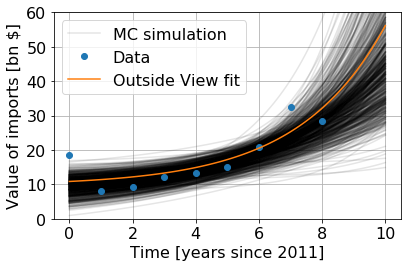

In [37]:
# Generate fits

n_fits = 1000
fit_params_gen = np.random.multivariate_normal(popt, pcov, n_fits)

# fit_params = fit_params_gen
# Comment out the line above and uncomment the below lines to clean to fit based on some criteria. 
# Be very careful throwing only a lot of data though!!
fit_params = []
n_removed = 0
for fit_list in fit_params_gen:
    if fit_list[0] < 0:
        n_removed += 1
        n_fits -= 1
    else:
        fit_params.append(fit_list)

# Plot MC simualtions and build MC data
fig, ax_mc = plt.subplots(1,1)

final_vals = []
for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, 10, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
    
    final_vals.append(outside_func(np.array([10]), *popt_mc)[0])
    
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, 10, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label='Outside View fit')

ax_mc.set_xlabel('Time [years since 2011]')
ax_mc.set_ylabel('Value of imports [bn $]')

ax_mc.set_ylim([0,60])

ax_mc.grid()
ax_mc.legend()

plt.tight_layout()

## Histogramming

In [38]:
# cset_boundaries = [20, 30, 40, 50]
# bins = [ax_mc.get_ylim()[0], 20, 30, 40, 50, ax_mc.get_ylim()[1]]

# fig, ax_hist = plt.subplots(1,1)

# n, bins, patches = ax_hist.hist(np.array(final_vals), bins, color='k', orientation='horizontal')
# ax_hist.set_ylim(ax_mc.get_ylim())

# ax_hist.set_xlabel('Num occurences of {} sims'.format(n_fits))

# for boundary in cset_boundaries:
#     ax_hist.axhline(boundary, color='r')
    
# text_offset = (max(bins) - min(bins)) / 100
# percentages = [int(n_val / n_fits * 100) for n_val in n]
# for n_val, bin_min, percent in zip(n, bins[:-1], percentages):
#     ax_hist.text(n_val, bin_min + text_offset, '{}%'.format(percent))

## Combine plots

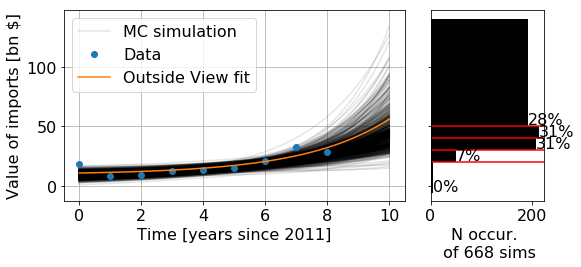

In [40]:
# Plot MC simualtions and build MC data
fig, [ax_mc, ax_hist] = plt.subplots(1, 2, figsize=(8, 4), sharey=True, gridspec_kw={'width_ratios': [3, 1]})

for i, popt_mc in enumerate(fit_params):
    label = 'MC simulation' if i == 0 else None 
    t_plot = np.linspace(0, 10, 100)
    ax_mc.plot(t_plot, outside_func(t_plot, *popt_mc), 'k', alpha=0.1, label=label)
        
# Plot original data and fit
ax_mc.plot(data['date'], data['quant'], 'o', label='Data')
t_plot = np.linspace(0, 10, 100)
ax_mc.plot(t_plot, outside_func(t_plot, *popt), label='Outside View fit')

ax_mc.set_xlabel('Time [years since 2011]')
ax_mc.set_ylabel('Value of imports [bn $]')

ax_mc.grid()
ax_mc.legend()




# Plot histogram
cset_boundaries = [20, 30, 40, 50]
bins = [ax_mc.get_ylim()[0], 20, 30, 40, 50, ax_mc.get_ylim()[1]]

n, bins, patches = ax_hist.hist(np.array(final_vals), bins, color='k', orientation='horizontal')
# ax_hist.set_ylim(ax_mc.get_ylim())

ax_hist.set_xlabel('N occur. \n of {} sims'.format(n_fits))

for boundary in cset_boundaries:
    ax_hist.axhline(boundary, color='r')
    
text_offset = (max(bins) - min(bins)) / 100
percentages = [int(n_val / n_fits * 100) for n_val in n]
for n_val, bin_min, percent in zip(n, bins[:-1], percentages):
    ax_hist.text(n_val, bin_min + text_offset, '{}%'.format(percent))


plt.tight_layout()

# Generate final forcast

Before I saw any data, I would have put equal confidence in each of the 5 bins, so my prior was {0.2, 0.2, 0.2, 0.2, 0.2}.

I then tried to incorporate information about historical trends alone by doing a linear fit on the data, and estimating the distribution for 2021 given the uncertainty in this linear fit. From this curve fitting, my best estimate of the probabilities of the (linear) trend reaching the values {<20bn, 20-30bn, 30-40bn, 40-50bn, >50bn} is {1%, 36%, 59%, 3%, 0%} respectively (For how I arrived at these, see https://github.com/cphenicie/forecasts/tree/main/Foretell in the file 20201118_value_of_Chinese_semiconductor-imports). 

I couldn't figure out how to update my prior values using these trend-fit values using Bayes theorem in a reasonable amount of time. So, instead, I arbitrarily assigned 50% confidence to my prior values and 50% confidence to these trend-fits values. I then arrived at updated values by taking the mean of the prior with the trend-fit value (0.5 * [prior] + (1-0.5) * [trend-fit value]), and then normalizing the resulting distribution

Finally, I'm unsure how to incorporate any information about policy to update this further. For instance, I could see (at least unilateral) US export controls leading to this trend decreasing (less supply for China) but also increasing (Chinese companies fearing future multilateral action may stock up on equipment sooner rather than later).

In [41]:
prior = [0.2, 0.2, 0.2, 0.2, 0.2]
fit = [0.01, 0.36, 0.59, 0.03, 0.00]
c_fit = 0.5
mean_vals = [(1-c_fit) * p + c_fit * f for p, f in zip(prior, fit)]
final_dist = mean_vals / np.sum(mean_vals)
final_dist

array([0.10552764, 0.28140704, 0.39698492, 0.11557789, 0.10050251])